### Build/train DNN model for DO.  Use model to predict from validation data (validation905.xlsx) and save output.

---
---
---

##### Make sure we have these modules

In [1]:
!pip install -q pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install -q sklearn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!pip install -q openpyxl

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


##### Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
np.set_printoptions(precision=3, suppress=True)

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.0


In [7]:
from sklearn.metrics import r2_score

In [8]:
from sklearn.metrics import mean_absolute_error

##### Prep GPU

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
---
---

#### Some useful functions

##### Build and compile a dense NN with a normalizer

In [10]:
def build_and_compile_model(normalizer):
  model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [11]:
def plot_loss(history, var_name):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel(f'Error [{var_name}]')
  plt.legend()
  plt.grid(True)

---
---
---

#### Begin DO

In [12]:
data = pd.read_excel("training905.xlsx",na_values="NaN",  engine='openpyxl')

In [13]:
data.head()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
0,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,10.000,7.870,1882.000,27.000,8.900,21.300,0.810,0.310
1,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.759,7.842,1901.641,26.753,9.174,21.555,0.799,0.289
2,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.816,7.858,1923.555,26.720,9.551,21.220,0.595,0.275
3,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.806,7.856,1837.397,26.445,8.348,21.830,0.916,0.362
4,2016-01-01 00:15:00,2016,00:15:00,1,1,1,2.337,10.000,7.860,1885.000,27.000,9.000,21.300,0.810,0.310


In [14]:
data.tail()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
433327,2020-12-31 23:30:00,2020,23:30:00,12,31,5,1.815,7.747,8.394,699.830,NaN,12.233,13.181,-0.072,0.123
433328,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.600,8.340,715.000,NaN,12.200,13.400,0.160,0.180
433329,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.701,8.338,695.460,NaN,11.723,13.465,0.108,0.205
433330,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,8.070,8.304,681.666,NaN,12.485,12.408,-0.058,0.244
433331,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.495,8.356,756.958,NaN,11.342,13.893,0.065,0.165


In [15]:
data.columns

Index(['datetime', 'Year', 'Time', 'Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH',
       'EC', 'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4'],
      dtype='object')

In [16]:
data = data.fillna(data.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


Save the clean data as csv.

In [17]:
data.to_csv('training905.csv', index=False)

In [18]:
data.columns

Index(['datetime', 'Year', 'Time', 'Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH',
       'EC', 'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4'],
      dtype='object')

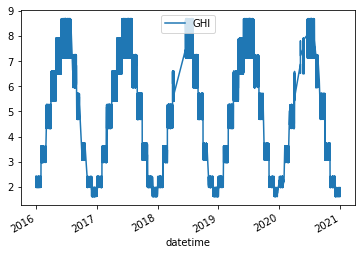

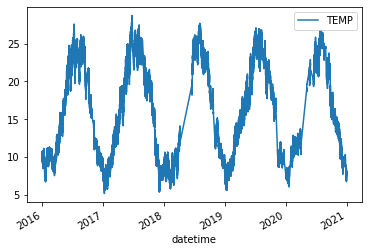

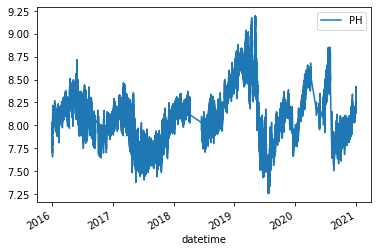

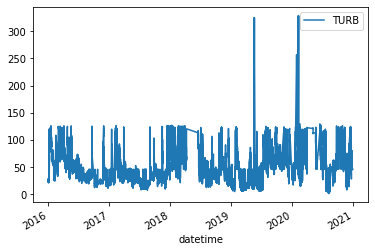

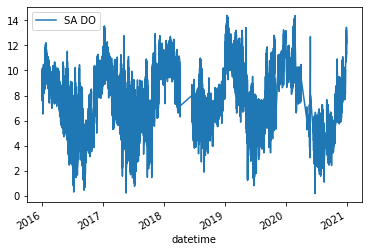

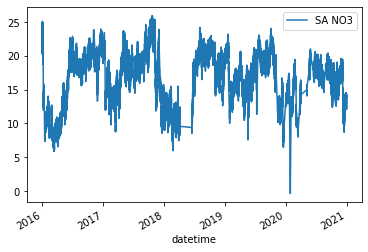

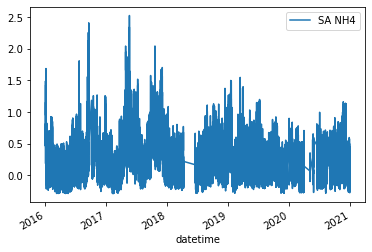

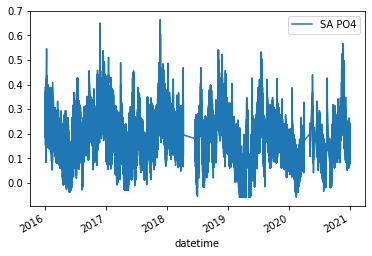

In [19]:
for val in ['GHI', 'TEMP', 'PH',
       'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4']:
    data.plot(x='datetime', y=val)

### Split the data into train and test

Now split the dataset into a training set and a test set. Note use of sample. That grabs a random selection of data of the desired size.

We will use the test set for validation in training phase of our models.

In [20]:
train_data = data.sample(frac=0.9, random_state=0)
test_data = data.drop(train_data.index)

In [21]:
len(train_data)

389999

In [22]:
len(test_data)

43333

#### Look at ranges of data...

In [23]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,389999.0,2017.800035,1.354273,2016.000,2017.000,2018.000,2019.0000,2020.000
Month,389999.0,6.542648,3.512460,1.000,3.000,7.000,10.0000,12.000
Day,389999.0,15.617479,8.850489,1.000,8.000,16.000,23.0000,31.000
Week,389999.0,2.686563,1.279137,1.000,2.000,3.000,4.0000,5.000
GHI,389999.0,4.797451,2.206960,1.620,2.387,4.872,6.8390,8.690
TEMP,389999.0,16.067202,6.217601,5.132,10.099,15.700,22.2000,28.733
PH,389999.0,8.084271,0.292527,7.255,7.895,8.067,8.2340,9.200
EC,389999.0,1590.915175,580.889936,363.915,1097.687,1688.593,2071.0640,2759.993
TURB,389999.0,45.990564,25.651363,1.306,26.796,40.543,60.9565,328.799
SA DO,389999.0,7.659964,2.404185,0.218,5.837,7.700,9.5460,14.384


### Split features from targets

Separate the target values from the features.  

We're building 4 models:

- month, day, week, ghi, temp, ph, ec, turb, to predict DO

- month, day, week, ghi, temp, ph, ec, turb, Do to predict NO3

- month, day, week, ghi, temp, ph, ec, turb, Do, NO3 to predict NH4

- month, day, week, ghi, temp, ph, ec, turb, Do, NO3, NH4 o predict PO4

Columns: 
['datetime', 'Year', 'Time', 'Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH',
       'EC', 'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4'

In [24]:
do_features = [ 'Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH', 'EC', 'TURB']

In [25]:
do_target = ['SA DO']

In [26]:
train_data[do_features].head()

,Month,Day,Week,GHI,TEMP,PH,EC,TURB
121339,4,12,2,5.459,17.320,7.894,1340.190,45.961843
288783,1,15,3,2.237,8.040,8.712,1853.642,21.243000
101841,2,5,1,3.112,9.368,8.154,1060.954,113.972000
285799,1,7,1,2.201,6.825,8.559,1820.651,22.572000
380441,2,13,2,3.629,11.660,8.271,1142.789,36.890000


In [27]:
test_data[do_features].head()

,Month,Day,Week,GHI,TEMP,PH,EC,TURB
21,1,1,1,1.987,9.766,7.848,1907.415,27.995
27,1,1,1,2.099,9.803,7.842,1849.197,26.633
43,1,1,1,2.024,10.438,7.854,1892.609,28.255
46,1,1,1,2.155,9.697,7.864,1851.037,27.491
92,1,1,1,2.275,10.000,7.830,1899.000,27.000


In [28]:
train_data[do_target].head()

,SA DO
121339,8.607
288783,12.160
101841,9.916
285799,12.320
380441,11.398


In [29]:
test_data[do_target].head()

,SA DO
21,9.387
27,9.675
43,8.153
46,9.445
92,8.800


In [30]:
train_data[do_features].describe().transpose()[['50%', 'mean', 'std' ]]

,50%,mean,std
Month,7.000,6.542648,3.512460
Day,16.000,15.617479,8.850489
Week,3.000,2.686563,1.279137
GHI,4.872,4.797451,2.206960
TEMP,15.700,16.067202,6.217601
PH,8.067,8.084271,0.292527
EC,1688.593,1590.915175,580.889936
TURB,40.543,45.990564,25.651363


### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [31]:
do_normalizer = preprocessing.Normalization()

In [32]:
do_normalizer.adapt(np.array(train_data[do_features]))

In [33]:
print(do_normalizer.mean.numpy())

[   6.543   15.617    2.687    4.797   16.067    8.084 1590.915   45.991]


In [34]:
first = np.array(train_data[do_features][:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', do_normalizer(first).numpy())

First example: [[   4.     12.      2.      5.46   17.32    7.89 1340.19   45.96]]

Normalized: [[-0.72 -0.41 -0.54  0.3   0.2  -0.65 -0.43 -0.  ]]


#### Start with linear regression

In [35]:
do_linear_model = tf.keras.Sequential([
    do_normalizer,
    layers.Dense(units=1)
])

#### Call the model to build its weight matrices

In [36]:
do_linear_model.predict(train_data[do_features][:10])

array([[-0.998],
       [ 2.946],
       [ 0.184],
       [ 2.087],
       [ 0.473],
       [-1.451],
       [-0.111],
       [-0.025],
       [ 0.343],
       [ 0.155]], dtype=float32)

#### Compile

In [37]:
do_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

#### Train

In [38]:
%%time
history = do_linear_model.fit(
    train_data[do_features], train_data[do_target], 
    epochs=20,
    # don't suppress logging
    verbose=1,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/20
10969/10969 [==============================] - 12s 1ms/step - loss: 1.2943 - val_loss: 1.1441
Epoch 2/20
10969/10969 [==============================] - 16s 1ms/step - loss: 1.1631 - val_loss: 1.1358
Epoch 3/20
10969/10969 [==============================] - 16s 1ms/step - loss: 1.1619 - val_loss: 1.1416
Epoch 4/20
10969/10969 [==============================] - 14s 1ms/step - loss: 1.1584 - val_loss: 1.1335
Epoch 5/20
10969/10969 [==============================] - 14s 1ms/step - loss: 1.1588 - val_loss: 1.1466
Epoch 6/20
10969/10969 [==============================] - 9s 831us/step - loss: 1.1614 - val_loss: 1.1760
Epoch 7/20
10969/10969 [==============================] - 8s 768us/step - loss: 1.1625 - val_loss: 1.1402
Epoch 8/20
10969/10969 [==============================] - 16s 1ms/step - loss: 1.1621 - val_loss: 1.1476
Epoch 9/20
10969/10969 [==============================] - 11s 1ms/step - loss: 1.1569 - val_loss: 1.1355
Epoch 10/20
10969/10969 [============================

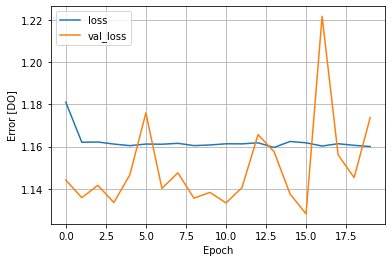

In [39]:
plot_loss(history, 'DO')

##### Eval this model and store results

In [40]:
test_results = {}

test_results['do_linear_model'] = do_linear_model.evaluate(
    test_data[do_features], test_data[do_target], verbose=0)

In [41]:
do_linear_model.metrics_names

['loss']

In [42]:
test_results

{'do_linear_model': 1.1734834909439087}

In [43]:
do_lin_model_yhat = do_linear_model.predict(test_data[do_features])

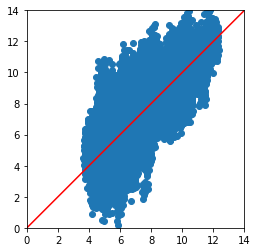

In [44]:
a = plt.axes(aspect='equal')
plt.scatter(do_lin_model_yhat, test_data[do_target])
lims = [0, 14]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')

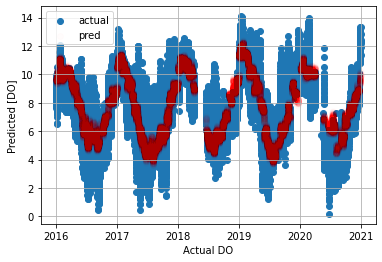

In [45]:
plt.scatter(test_data['datetime'], test_data[do_target], label='actual')
plt.scatter(test_data['datetime'], do_lin_model_yhat, color='red', alpha=0.01, label='pred')
plt.xlabel('Actual DO')
plt.ylabel('Predicted [DO]')
plt.legend()
plt.grid(True)

In [46]:
r2_score(test_data[do_target], do_lin_model_yhat)

0.6300214253355376

#### Model is not great, but we didn't expect it to be.

### DNN model for DO

In [47]:
do_dnn_model = build_and_compile_model(do_normalizer)

In [48]:
do_dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [49]:
%%time
history = do_dnn_model.fit(
    train_data[do_features], train_data[do_target], 
    epochs=20,
    # don't suppress logging
    verbose=1,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/20
10969/10969 [==============================] - 17s 2ms/step - loss: 1.0122 - val_loss: 0.6724
Epoch 2/20
10969/10969 [==============================] - 14s 1ms/step - loss: 0.6417 - val_loss: 0.6218
Epoch 3/20
10969/10969 [==============================] - 12s 1ms/step - loss: 0.6070 - val_loss: 0.6096
Epoch 4/20
10969/10969 [==============================] - 10s 925us/step - loss: 0.5860 - val_loss: 0.5832
Epoch 5/20
10969/10969 [==============================] - 16s 1ms/step - loss: 0.5732 - val_loss: 0.5551
Epoch 6/20
10969/10969 [==============================] - 16s 1ms/step - loss: 0.5635 - val_loss: 0.5400
Epoch 7/20
10969/10969 [==============================] - 18s 2ms/step - loss: 0.5537 - val_loss: 0.5578
Epoch 8/20
10969/10969 [==============================] - 13s 1ms/step - loss: 0.5448 - val_loss: 0.5454
Epoch 9/20
10969/10969 [==============================] - 14s 1ms/step - loss: 0.5437 - val_loss: 0.5313
Epoch 10/20
10969/10969 [============================

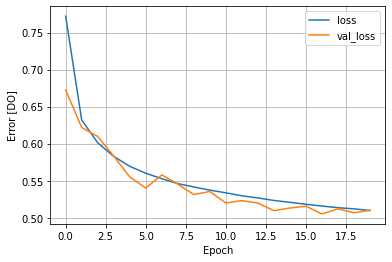

In [50]:
plot_loss(history, 'DO')

##### Eval this model and store results

In [51]:
test_results['do_dnn_model'] = do_dnn_model.evaluate(
    test_data[do_features], test_data[do_target], verbose=0)

In [52]:
test_results

{'do_linear_model': 1.1734834909439087, 'do_dnn_model': 0.5130026936531067}

In [53]:
do_dnn_model_yhat = do_dnn_model.predict(test_data[do_features])

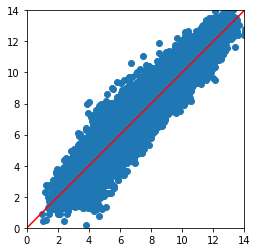

In [54]:
a = plt.axes(aspect='equal')
plt.scatter(do_dnn_model_yhat, test_data[do_target])
lims = [0, 14]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')

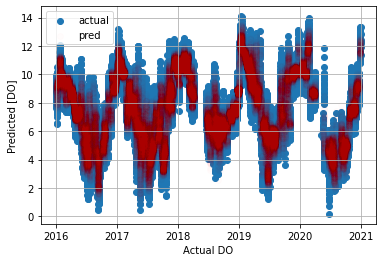

In [55]:
plt.scatter(test_data['datetime'], test_data[do_target], label='actual')
plt.scatter(test_data['datetime'], do_dnn_model_yhat, color='red', alpha=0.01, label='pred')
plt.xlabel('Actual DO')
plt.ylabel('Predicted [DO]')
plt.legend()
plt.grid(True)

In [56]:
r2_score(test_data[do_target], do_dnn_model_yhat)

0.9218161586097426

#####  Model captures much more of the variation.

### Save model and predictions

In [57]:
do_dnn_model.save('do_dnn_model')

INFO:tensorflow:Assets written to: do_dnn_model/assets


In [58]:
reload_do_dnn_model = tf.keras.models.load_model('do_dnn_model')

check reloaded model

In [59]:
test_results['reloaded'] = reload_do_dnn_model.evaluate(
    test_data[do_features], test_data[do_target], verbose=0)

In [60]:
test_results

{'do_linear_model': 1.1734834909439087,
 'do_dnn_model': 0.5130026936531067,
 'reloaded': 0.5130026936531067}

In [61]:
pd.DataFrame(test_results, index=['Mean absolute error [DO]']).T

,Mean absolute error [DO]
do_linear_model,1.173483
do_dnn_model,0.513003
reloaded,0.513003


##### Get the validation data and examine

In [62]:
val_data = pd.read_excel("validation905.xlsx",na_values="NaN",  engine='openpyxl')

In [63]:
val_data.head()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
0,2021-01-04 19:00:00,2021,19:00:00,1,4,1,2.386,7.3,8.39,679,51,11.7,12.5,0.13,0.16
1,2021-01-04 19:15:00,2021,19:15:00,1,4,1,2.138,7.3,8.38,680,54,11.7,12.5,0.13,0.16
2,2021-01-04 19:30:00,2021,19:30:00,1,4,1,2.026,7.3,8.38,681,56,11.7,12.5,0.13,0.16
3,2021-01-04 19:45:00,2021,19:45:00,1,4,1,2.149,7.3,8.38,681,58,11.7,12.6,0.13,0.16
4,2021-01-04 20:00:00,2021,20:00:00,1,4,1,2.370,7.3,8.38,680,58,11.7,12.5,0.14,0.16


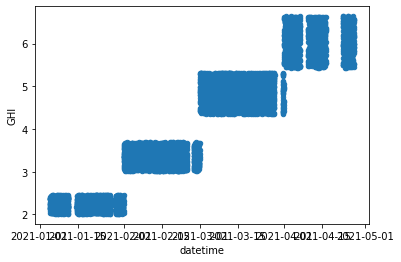

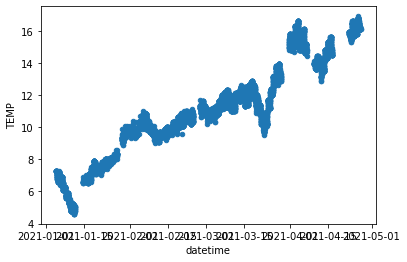

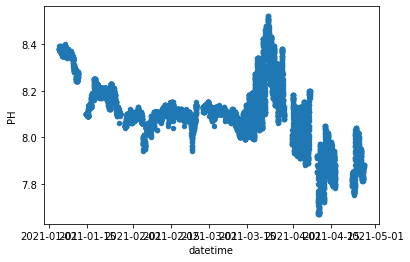

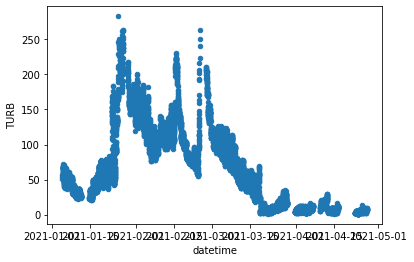

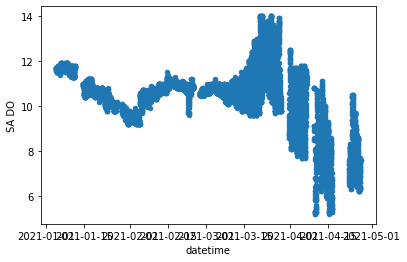

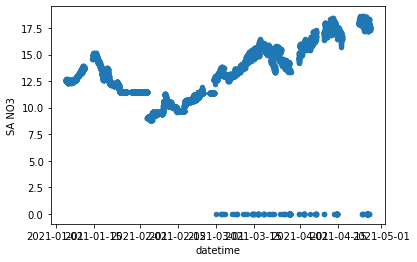

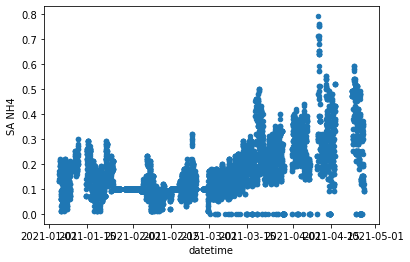

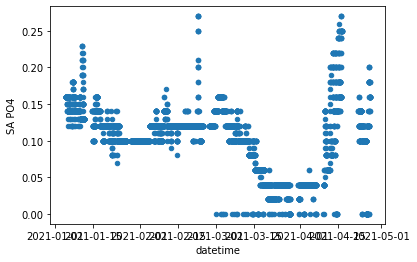

In [64]:
for val in ['GHI', 'TEMP', 'PH',
       'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4']:
    val_data.plot(x='datetime', y=val, kind='scatter')

##### Predict DO

In [65]:
do_val_yhats = reload_do_dnn_model.predict(val_data[do_features])

In [66]:
r2_score(val_data[do_target], do_val_yhats)

-2.050688301584516

In [67]:
mean_absolute_error(val_data[do_target], do_val_yhats)

1.8951666345132276

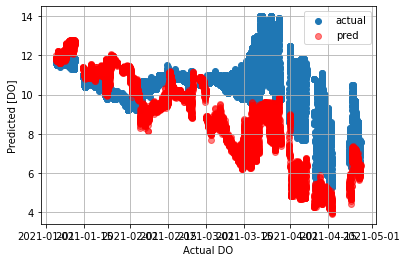

In [68]:
plt.scatter(val_data['datetime'], val_data[do_target], label='actual')
plt.scatter(val_data['datetime'], do_val_yhats, color='red', alpha=0.5, label='pred')
plt.xlabel('Actual DO')
plt.ylabel('Predicted [DO]')
plt.legend()
plt.grid(True)

Save the predictions along with time and actual DO.

In [69]:
do_val_output = pd.DataFrame()

In [70]:
do_val_output['datetime'] = val_data['datetime']

In [71]:
do_val_output['predicted DO'] = do_val_yhats

In [72]:
do_val_output['actual DO'] = val_data['SA DO']

In [73]:
do_val_output.head()

,datetime,predicted DO,actual DO
0,2021-01-04 19:00:00,12.039164,11.7
1,2021-01-04 19:15:00,11.940874,11.7
2,2021-01-04 19:30:00,11.891972,11.7
3,2021-01-04 19:45:00,11.883848,11.7
4,2021-01-04 20:00:00,11.894768,11.7


<AxesSubplot:xlabel='datetime'>

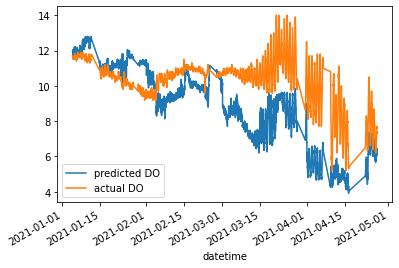

In [74]:
do_val_output.plot(x='datetime')

In [75]:
do_val_output.to_csv('dnn_predicted_do.csv', index=False)

##### check saved output

In [76]:
out = pd.read_csv('dnn_predicted_do.csv')

In [77]:
out.head()

,datetime,predicted DO,actual DO
0,2021-01-04 19:00:00,12.039164,11.7
1,2021-01-04 19:15:00,11.940874,11.7
2,2021-01-04 19:30:00,11.891972,11.7
3,2021-01-04 19:45:00,11.883848,11.7
4,2021-01-04 20:00:00,11.894768,11.7


<AxesSubplot:xlabel='datetime'>

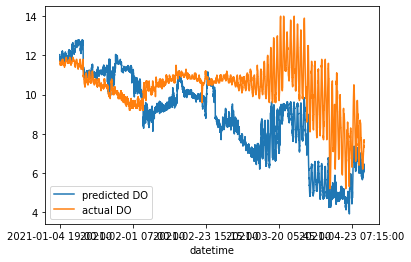

In [78]:
out.plot(x='datetime')